In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV,  KFold, cross_validate
import seaborn as sns
import sys
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import statistics
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score

# Defining train_model function

In [2]:
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    base_model = DecisionTreeClassifier(random_state=42)
    adaboost_model = AdaBoostClassifier(base_model, random_state=42)
    model2 = RandomForestClassifier(random_state=42)
    model = VotingClassifier(estimators=[('adaboost', adaboost_model), ('random_forest', model2)], voting='hard')
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted')
        }
    param_grid = {
        'random_forest__n_estimators': [100, 1000, 2000],
        'random_forest__max_depth': [None, 10, 20, 30, 40, 50, 60],
        'random_forest__max_features': ['auto', 'sqrt', 'log2'],
        'random_forest__min_samples_split': [2, 5, 10, 20, 40],
        'random_forest__min_samples_leaf': [1, 2, 4, 8, 16],
        'random_forest__bootstrap': [True, False],
        'adaboost__n_estimators': [100, 1000, 2000],
        'adaboost__learning_rate': [0.1, 0.5, 1.0]
    }
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_model.fit(X_train, y_train)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    results = cross_validate(estimator=best_model, X=X, y=y, cv=kfold, scoring = scoring, n_jobs=-1)
    predictions = best_model.predict(X_test)
    return results, best_model, predictions, y_test

# Main code

In [3]:
# Read dataset
df = pd.read_csv(r'output_combined.csv')
# Prep the dataset
df = df.dropna()
df = df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1)
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.dayofyear
df = df.drop(df.index[-1])
replacement_dict = {'Non': 0, 'NPF': 1, 'undefined': 2}
df['day.type'] = df['day.type'].replace(replacement_dict)
df_orig = df

# Iteration 1

c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\ensemble\_voting.py", line 349, in fit
    return super().fit(X, transformed_y, sample_weight)
  F

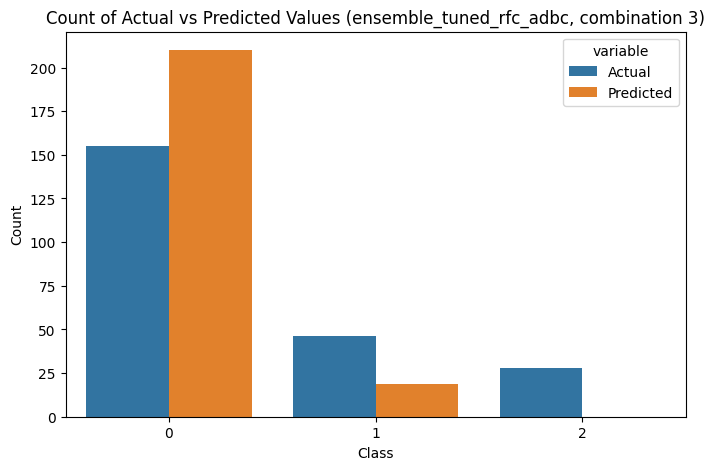

In [4]:
# Split dataset
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type", "NH3", "SO4", "NH4", "SO2"]].copy()
df = df_selected
X = df.drop(columns=["day.type"])
y = df["day.type"] 
# Unpack results
results, model, predictions, y_test = train_model(X=X, y=y)
# Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])

# Redirect stdout to a file
with open('ensemble_tuned_rfc_adbc_combination_3.txt', 'w') as file:
    sys.stdout = file 
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

df_show = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()})

# Plot the count of actual vs predicted values
plt.figure(figsize=(8, 5))
sns.countplot(x='value', hue='variable', data=pd.melt(df_show[['Actual', 'Predicted']]))
plt.title('Count of Actual vs Predicted Values (ensemble_tuned_rfc_adbc, combination 3)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('ensemble_tuned_rfc_adbc_combination_3.png', dpi=300)

# Iteration 2

c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\ensemble\_voting.py", line 349, in fit
    return super().fit(X, transformed_y, sample_weight)
  Fi

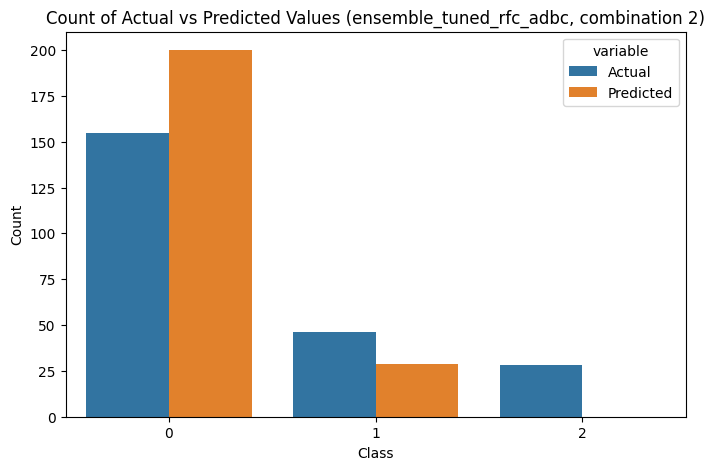

In [5]:
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type", "NH3", "SO4"]].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]
# Unpack results
results, model, predictions, y_test = train_model(X=X, y=y)
# Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])

# Redirect stdout to a file
with open('ensemble_tuned_rfc_adbc_combination_2.txt', 'w') as file:
    sys.stdout = file 
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

df_show = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()})

# Plot the count of actual vs predicted values
plt.figure(figsize=(8, 5))
sns.countplot(x='value', hue='variable', data=pd.melt(df_show[['Actual', 'Predicted']]))
plt.title('Count of Actual vs Predicted Values (ensemble_tuned_rfc_adbc, combination 2)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('ensemble_tuned_rfc_adbc_combination_2.png', dpi=300)

# Iteration 3

c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\ensemble\_voting.py", line 349, in fit
    return super().fit(X, transformed_y, sample_weight)
  Fi

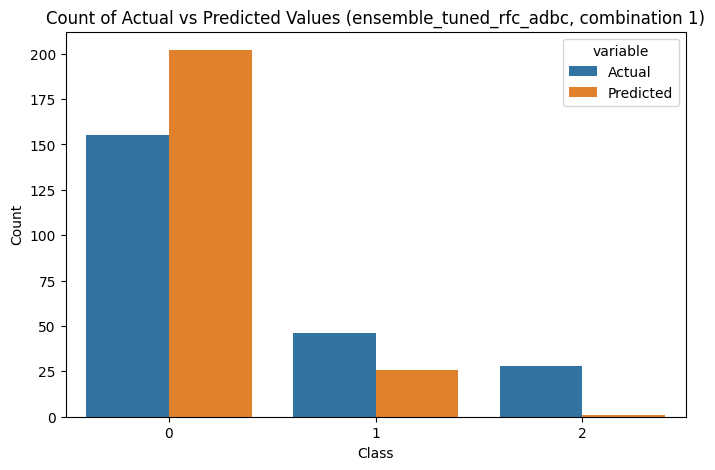

In [6]:
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type"]].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]
# Unpack results
results, model, predictions, y_test = train_model(X=X, y=y)
# Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])

# Redirect stdout to a file
with open('ensemble_tuned_rfc_adbc_combination_1.txt', 'w') as file:
    sys.stdout = file 
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

df_show = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()})

# Plot the count of actual vs predicted values
plt.figure(figsize=(8, 5))
sns.countplot(x='value', hue='variable', data=pd.melt(df_show[['Actual', 'Predicted']]))
plt.title('Count of Actual vs Predicted Values (ensemble_tuned_rfc_adbc, combination 1)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('ensemble_tuned_rfc_adbc_combination_1.png', dpi=300) 